# Installs

The only package we will need is the **einops** package. This will be used to create a nice GIF animation of our DDPM model.

In [1]:
!pip3 install --upgrade pip
!pip3 install einops

# Imports and Definitions

In [2]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

## Execution options

Here's a few options you should set:

 - `no_train` specifies whether you want to skip the training loop and just use a pre-trained model. If you haven't trained a model already using this notebook, keep this as `False`. If you want to use a pre-trained model, load it in the colab filesystem.

- `fashion` specifies whether you want to use the Fashion-MNIST dataset (`True`) or not and use the MNIST dataset instead (`False`).

- `batch_size`, `n_epochs` and `lr` are your typical training hyper-parameters. Notice that `lr=0.001` is the hyper-parameter used by the authors.


In [3]:
no_train = False
fashion = True
batch_size = 32
n_epochs = 200
lr = 0.001

In [4]:
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

# Utility functions

Following are two utility functions: `show_images` allows to display images in a square-like pattern with a custom title, while `show_fist_batch` simply shows the images in the first batch of a DataLoader object.

In [5]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [6]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

In [7]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
from aoi_data import train_data

# ds_fn = FashionMNIST if fashion else MNIST
# dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(train_data, batch_size, shuffle=True)

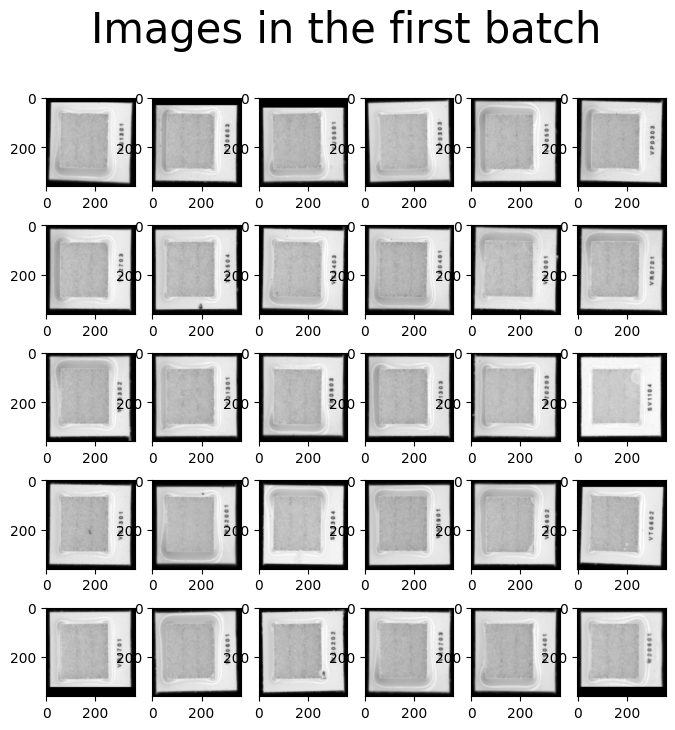

In [8]:
# Optionally, show a batch of regular images
show_first_batch(loader)

## Getting device

If you are running this codebook from Google Colab, make sure you are using a GPU runtime. For non-pro users, typically a *Tesla T4* GPU is provided.

In [9]:
# Getting device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda:3	NVIDIA GeForce RTX 3090


# Defining the DDPM module

We now proceed and define a DDPM PyTorch module. Since in principle the DDPM scheme is independent of the model architecture used in each denoising step, we define a high-level model that is constructed using a `network` parameter, as well as:

- `n_steps`: number of diffusion steps $T$;
- `min_beta`: value of the first $\beta_t$ ($\beta_1$);
- `max_beta`: value of the last  $\beta_t$ ($\beta_T$);
- `device`: device onto which the model is run;
- `image_chw`: tuple contining dimensionality of images.

The `forward` process of DDPMs benefits from a nice property: We don't actually need to slowly add noise step-by-step, but we can directly skip to whathever step $t$ we want using coefficients $\alpha_bar$.

For the `backward` method instead, we simply let the network do the job.

Note that in this implementation, $t$ is assumed to be a `(N, 1)` tensor, where `N` is the number of images in tensor `x`. We thus support different time-steps for multiple images.

In [10]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 360,360)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Visualizing forward and backward

Now that we have defined the high-level functioning of a DDPM model, we can already define some related utility functions.

In particular, we will be showing the forward process (which is independent of the denoising network) with the `show_forward` method. 

We run the backward pass and generate new images with the `generate_new_images` method, but this time we will put more effort into the function and also make it such that a GIF image is created. Notice that in the paper (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al., two options are considered for $\sigma_t^2$:

- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$

In this implementation, they are both a few line-comments away. However, the two terms are rougly always the same and little difference is noticeable. By default, I choose the first option out of simplicity.

In [11]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [12]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=360, w=360):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

# UNet architecture

Okay great! All that concerns DDPM is down on the table already. So now we simply define an architecture that will be responsible of denoising the we should be good to go... Not so fast! While in principle that's true, we have to be careful to conditioning our model with the temporal information. 

Remember that the only term of the loss function that we really care about is $||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t)||^2$, where $\epsilon$ is some random noise and $\epsilon_\theta$ is the model's prediction of the noise. Now, $\epsilon_\theta$ is a function of both $x$ and $t$ and we don't want to have a distinct model for each denoising step (thousands of independent models), but instead we want to use a single model that takes as input the image $x$ and the scalar value indicating the timestep $t$.

To do so, in practice we use a sinusoidal embedding (function `sinusoidal_embedding`) that maps each time-step to a `time_emb_dim` dimension. These time embeddings are further mapped with some time-embedding MLPs (function `_make_te`) and added to tensors through the network in a channel-wise manner.

**NOTE:** This UNet architecture is purely arbitrary and was desined to work with 28x28 spatial resolution images.

In [13]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [14]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [15]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 360, 360), 1, 10),
            MyBlock((10, 360, 360), 10, 10),
            MyBlock((10, 360, 360), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 180, 180), 10, 20),
            MyBlock((20, 180, 180), 20, 20),
            MyBlock((20, 180, 180), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 90, 90), 20, 40),
            MyBlock((40, 90, 90), 40, 40),
            MyBlock((40, 90, 90), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 44, 44), 40, 20),
            MyBlock((20, 44, 44), 20, 20),
            MyBlock((20, 44, 44), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 3, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 90, 90), 80, 40),
            MyBlock((40, 90, 90), 40, 20),
            MyBlock((20, 90, 90), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 180, 180), 40, 20),
            MyBlock((20, 180, 180), 20, 10),
            MyBlock((10, 180, 180), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 360, 360), 20, 10),
            MyBlock((10, 360, 360), 10, 10),
            MyBlock((10, 360, 360), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 360, 360) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 360, 360)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 180, 180)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 90, 90)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 44, 44)

        # print(f" out3 shape : {out3.shape}")
        # print(f" up1(out_mid) shape : {self.up1(out_mid).shape}")
        
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 90, 90)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 90, 90)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 180, 180)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 180, 180)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 360, 360)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 360, 360)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

# Instantiating the model

We are finally done! Now we simply need to instantiate a model, optionally play a bit with it (show forward and backward processes) and write the usual code that defines a training loop for our model. When the model will be done training, we will test it's generative capabilities.

In [16]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

# Optional visualizations

In [17]:
# Optionally, load a pre-trained model that will be further trained
# ddpm.load_state_dict(torch.load(store_path, map_location=device))

In [18]:
# # Optionally, show the diffusion (forward) process
# show_forward(ddpm, loader, device)

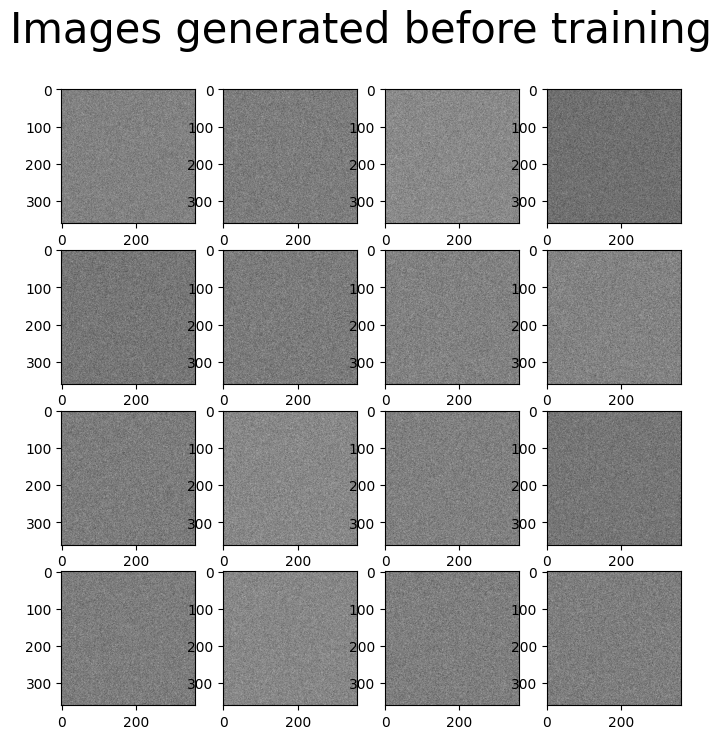

In [19]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

# Training loop

The training loop is fairly simple. With each batch of our dataset, we run the forward process on the batch. We use a different timesteps $t$ for each of the `N` images in our `(N, C, H, W)` batch tensor to guarantee more training stability. The added noise is a `(N, C, H, W)` tensor $\epsilon$.

Once we obtained the noisy images, we try to predict $\epsilon$ out of them with our network. We optimize with a simple Mean-Squared Error (MSE) loss.

In [20]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [21]:
# Training
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"
if not no_train:
    training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 1: 0.155 --> Best model ever (stored)


Epoch 2/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 2: 0.018 --> Best model ever (stored)


Epoch 3/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 3: 0.012 --> Best model ever (stored)


Epoch 4/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 4: 0.009 --> Best model ever (stored)


Epoch 5/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 5: 0.008 --> Best model ever (stored)


Epoch 6/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 6: 0.007 --> Best model ever (stored)


Epoch 7/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 7: 0.005 --> Best model ever (stored)


Epoch 8/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 8: 0.005 --> Best model ever (stored)


Epoch 9/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 9: 0.005 --> Best model ever (stored)


Epoch 10/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 10: 0.005


Epoch 11/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 11: 0.004 --> Best model ever (stored)


Epoch 12/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 12: 0.003 --> Best model ever (stored)


Epoch 13/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 13: 0.004


Epoch 14/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 14: 0.004


Epoch 15/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 15: 0.004


Epoch 16/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 16: 0.004


Epoch 17/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 17: 0.004


Epoch 18/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 18: 0.003 --> Best model ever (stored)


Epoch 19/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 19: 0.003 --> Best model ever (stored)


Epoch 20/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 20: 0.007


Epoch 21/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 21: 0.004


Epoch 22/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 22: 0.004


Epoch 23/200:   0%|          | 0/308 [00:00<?, ?it/s]

Loss at epoch 23: 0.003


Epoch 24/200:   0%|          | 0/308 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Testing the trained model

Time to check how well our model does. We re-store the best performing model according to our training loss and set it to evaluation mode. Finally, we display a batch of generated images and the relative obtained and nice GIF.

In [24]:
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded: Generating new images")

Model loaded: Generating new images


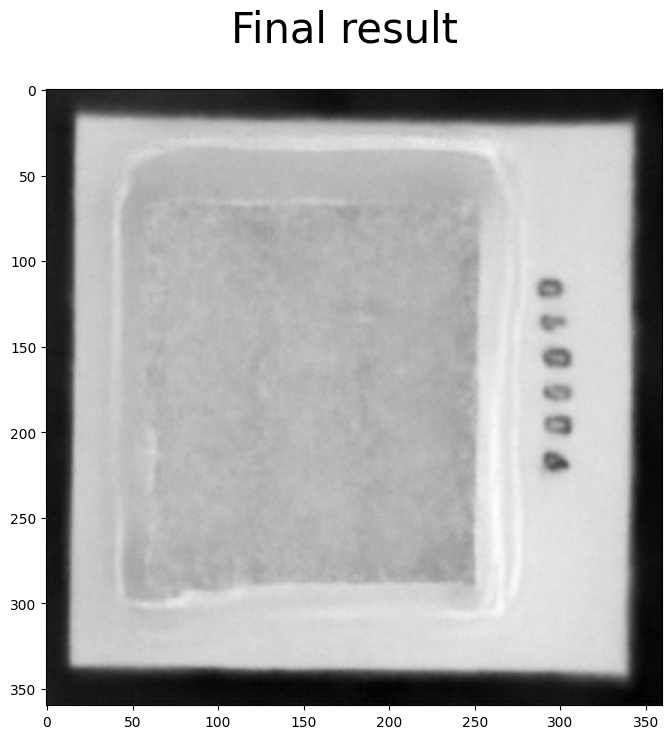

In [25]:
generated = generate_new_images(
        best_model,
        n_samples=1,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

# Visualizing the diffusion

In [ ]:
from IPython.display import Image

Image(open('fashion.gif' if fashion else 'mnist.gif','rb').read())